# Hierarchical (Agglomerative) Clustering Algorithm

Determines cluster assignments by building a hierarchy. This is implemented by either a bottom-up or a top-down approach:

- Agglomerative clustering is the bottom-up approach. It merges the two points that are the most similar until all points have been merged into a single cluster.

- Divisive clustering is the top-down approach. It starts with all points as one cluster and splits the least similar clusters at each step until only single data points remain. 

- These methods produce a tree-based hierarchy of points called a dendrogram. Similar to partitional clustering, in hierarchical clustering the number of clusters (k) is often predetermined by the user. Clusters are assigned by cutting the dendrogram at a specified depth that results in k groups of smaller dendrograms.

- Unlike many partitional clustering techniques, hierarchical clustering is a deterministic process, meaning cluster assignments won’t change when you run an algorithm twice on the same input data.

- The strengths of hierarchical clustering methods include: 
    
    -- They often reveal the finer details about the relationships between data objects.
    
    -- They provide an interpretable dendrogram.


- The weaknesses of hierarchical clustering methods include:
     
     -- They’re computationally expensive with respect to algorithm complexity.
     
     -- They’re sensitive to noise and outliers.


### Basic algorithm
1. Compute the proximity matrix

2. Let each data point be a cluster

3. Repeat
	
    3.1 Merge the two closest clusters >> this requires finding "closest" clusters!
	
    3.2 Update the proximity matrix


4. Until only a single cluster remains


In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import pairwise
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

Start with each record (node) and progressively combine two "nearest" clusters until there is one cluster, which consists of all records. 

**Single linkage**: min distance between the nearest pair of records in the two clusters (one record in each cluster)

**Complete linkage**: max distance

Results of the single and complete linkage methods depend only on the ordering of the inter-record distances. Linear transformations fo not affect the results. 

**Average linkage**: average distance (also called Unweighted Pair-Group Method using Averages - UPGMA)

**Centroid Linkage**: based on centroid distance, where centroids are represented by their mean values for each variable, forming a vector of means. Distance is the difference of these vectors. 

**Ward's method"**: accounts for loss of information while assigning nodes to a cluster. When a node is placed in a cluster, node's information is replaced by the cluster's information. Results in convex clusters, roughly equal sizes. This could be important in some applications such as creatign meaningful customer segments.

Documentation: https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html

## Example: Impact of Deregulation - how many models do we need for the analysis?

For each company that will be impacted, economists would create a separate model. However, as a data scientist we like to find other ways -- how about identifying similar companies, so that economists can focus on the vital few "groups" of companies!

#### Prep data

In [2]:
utilities_df = pd.read_csv("Utilities.csv")
# set row names to the utilities column
utilities_df.set_index('Company',inplace=True)
# convert to integer to float to avoid scale function warning
utilities_df = utilities_df.apply(lambda x: x.astype('float64'))
# normalize data
utilities_df_norm_s= (utilities_df - utilities_df.mean())/utilities_df.std()

#### Visually inspect fuel cost vs sales

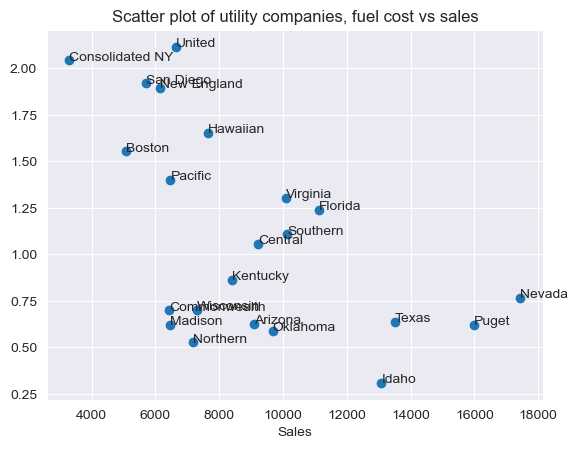

In [3]:
title = 'Scatter plot of utility companies, fuel cost vs sales'
utilities_df_figure = utilities_df.reset_index()
ax = utilities_df_figure.set_index('Sales')['Fuel_Cost'].plot(style='o',title=title)
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

label_point(utilities_df_figure.Sales, utilities_df_figure.Fuel_Cost, utilities_df_figure.Company, ax)

**Dendograms**
- Not only a visualization tool

- Cluster labels at any intermediate stage can be recovered

- For use in e.g. cross-tabulations

- Height on dendrogram = distance between merging clusters

- Height on dendrogram specifies max. distance between merging clusters


#### Single Linkage Example
Minimum distance between the nearest pair of records in the two clusters. Here default distance refers to Euclidian distance. 
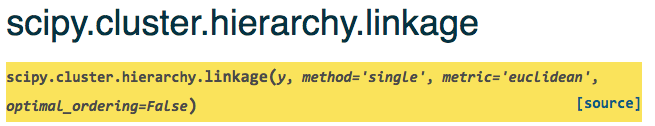

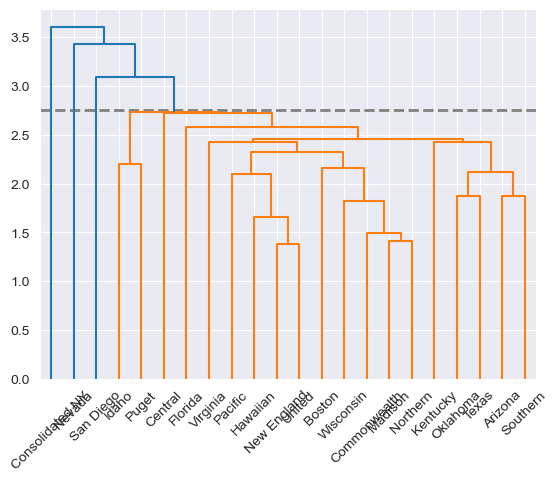

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
#in linkage() set argument method: single, complete, average, weighted, centroid, median, ward
Z = linkage(utilities_df_norm_s, method='single')
plt.axhline(y=2.75, c='grey', lw=2, linestyle='dashed')
dendrogram(Z, labels=utilities_df_norm_s.index, color_threshold=2.75);

Here blue shows cluster sizes of one, and the other colors show clusters with multiple members.

#### Average Linkeage Example

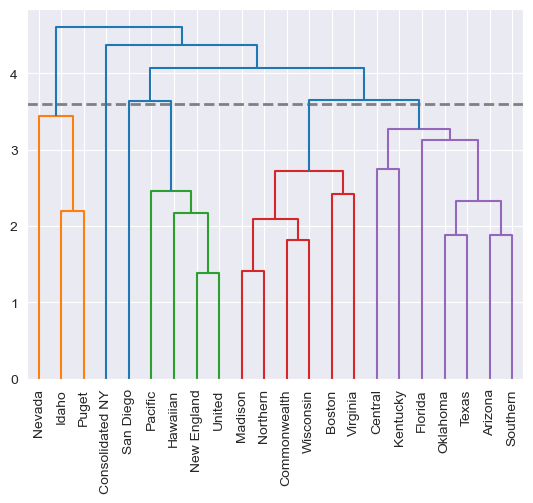

In [6]:
Z = linkage(utilities_df_norm_s, method='average')
plt.axhline(y=3.6, c='grey', lw=2, linestyle='dashed')
dendrogram(Z, labels=utilities_df_norm_s.index, color_threshold=3.6, leaf_rotation=90);

**Add graph title and labels**

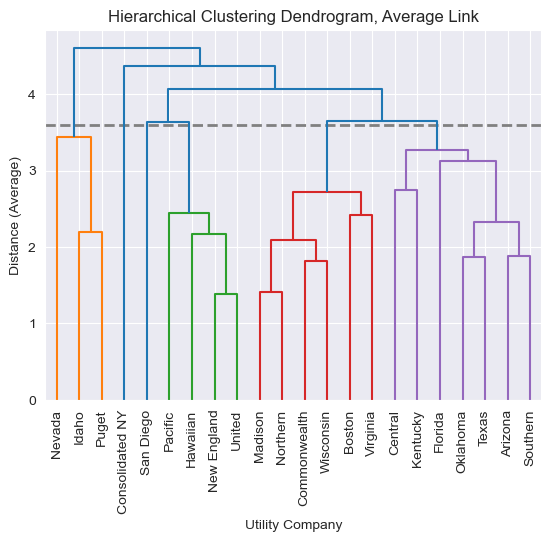

In [7]:
Z = linkage(utilities_df_norm_s, method='average')
# Plot title
plt.title('Hierarchical Clustering Dendrogram, Average Link')
# Plot axis labels
plt.xlabel('Utility Company')
plt.ylabel('Distance (Average)')
plt.axhline(y=3.6, c='grey', lw=2, linestyle='dashed')
dendrogram(Z, labels=utilities_df_norm_s.index, color_threshold=3.6, leaf_rotation=90);

#### Displaying the cluster membership

In [8]:
memb = fcluster(linkage(utilities_df_norm_s,method = 'average'),6,criterion='maxclust')
memb = pd.Series(memb,index=utilities_df_norm_s.index)

In [9]:
memb.head()

Company
Arizona            5
Boston             4
Central            5
Commonwealth       4
Consolidated NY    6
dtype: int32

In [10]:
for key,item in memb.groupby(memb):
    print (key,':',','.join(item.index))

1 : Idaho,Nevada,Puget
2 : Hawaiian,New England,Pacific,United
3 : San Diego
4 : Boston,Commonwealth,Madison,Northern,Virginia,Wisconsin
5 : Arizona,Central,Florida,Kentucky,Oklahoma,Southern,Texas
6 : Consolidated NY


#### Creating heatmaps to understand the clusters

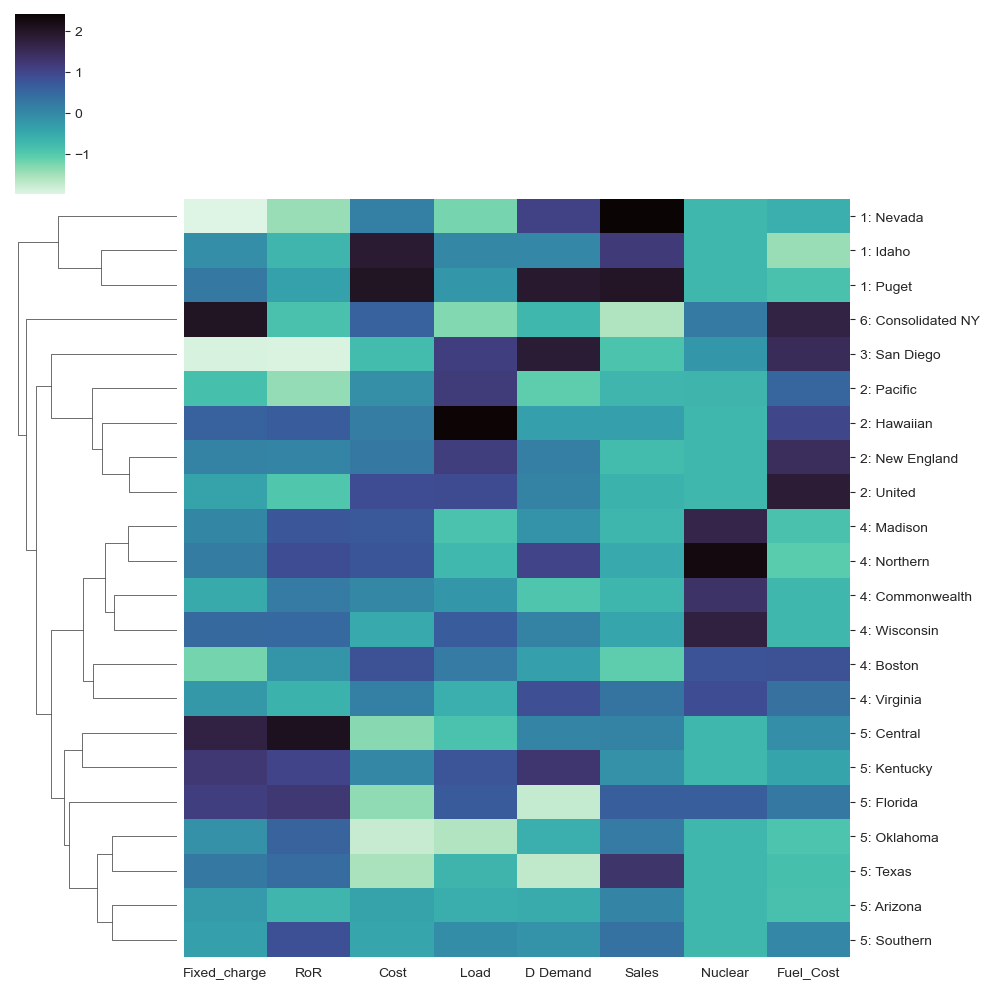

In [11]:
# set labels as cluster membership and utility name
utilities_df_norm_s.index = ['{}: {}'.format(cluster,state)
                             for cluster,state in zip(memb,utilities_df_norm_s.index)]
#plot heatmap
# '_r' suffix reverses the color mapping to large = dark
# method here refers to the linkage method: scipy.cluster.hierarchy.linkage() 
sns.clustermap(utilities_df_norm_s,method='average',col_cluster=False,cmap='mako_r');

**Interpreting the clustermap:**
    
> Cluster 2 high fuel cost group

> Cluster 4 have the nuclear utility companies

> Cluster 5 has high fixed charge and RoR

---